## Processing Test.csv file

In [ ]:
# For this file the same transformation and cleansing process from the train script.csv file will be executed.
# The explanation of the cleansing and transformation steps are explained in detail in the trian script.csv file, therefore,
# I asks the reader to go to this file to obtain more detailed information.

In [ ]:
2

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [ ]:
# Opening the dataset with pandas
test = pd.read_csv('properties_colombia_test.csv')

# The test dataset has 65850 rows and 26 columns.
test.shape

In [161]:
# As we can see several columns from the dataset have null values. We will apply the same transformation for each of the features, as with the train dataset. 
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65850 entries, 0 to 65849
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   start_date       65850 non-null  datetime64[ns]
 1   end_date         65850 non-null  datetime64[ns]
 2   latitud          65850 non-null  float64       
 3   longitud         65850 non-null  float64       
 4   departamento     65850 non-null  object        
 5   municipio        62193 non-null  object        
 6   rooms            9110 non-null   float64       
 7   bedrooms         13403 non-null  float64       
 8   bathrooms        52054 non-null  float64       
 9   surface_total    2314 non-null   float64       
 10  surface_covered  3305 non-null   float64       
 11  property_type    65850 non-null  object        
 12  localization     65850 non-null  object        
dtypes: datetime64[ns](2), float64(7), object(4)
memory usage: 6.5+ MB


In [ ]:
# We will use the missingno library to see the null values in an illustrative way.
import missingno as msno

msno.bar(test)
plt.show()

In [ ]:
# In order to clean the dataframe some columns will be deleted because different factors that are explained below:

# Unnamed: 0: As this column has no description and is imported when opening the data we proceed to erase it.

# id: Is the value to identify each property and does not have incidence in the price of properties.

test.drop(['Unnamed: 0', 'id'], axis=1, inplace=True)

In [ ]:
# A first step into the EDA (exploratory data analysis) is to verify if we have instances that are repeted.
# According to the following code we do not have properties that are duplicated.

# We can see that if we take out the 'id' and 'Unnamed: 0' columns, there are several entries with exactly the same data. This is because some properties are
# re-published when the publication period ends.

# As we can see, we have 504 properties that have been re-published, increasing the data with repeated records. 
test.duplicated().value_counts()

In [ ]:
'''# We obtain the index of the properties that are duplicated and use them to drop the repeated records.
repeated_properties = train[train.duplicated() == True].index
train.drop(repeated_properties, axis = 0, inplace=True)

# After deleting the dupliacated records we have 197045 rows.
train.shape'''

## Null Values Transformation/Imputation

In [ ]:
# Ad the ad_type column just have one value for all the records we proceed to erase it as it is not meaningful for the model.
test.ad_type.value_counts()
test.drop('ad_type', axis=1, inplace=True)

# As the start_date column and the created_on columns are the same we proceed to drop one of the 2 columns
test[test.start_date != test.created_on]
test.drop('created_on',axis=1,inplace=True)

# Then we transform the date columns to datetime variables.
test['start_date'] = test['start_date'].apply(lambda x: pd.to_datetime(x))

# For the end_date that has dates with 9999 as year it is not possible to simply change it to datetime type. Therefore, some different transformation has to be executed.
# As these variables are not going to be used in the ML model nor influence it, these values are arbitrary changed for the 2022 year. 
test['end_date'] = test['end_date'].apply(lambda x: pd.to_datetime(x) if x[:4]!='9999'else pd.to_datetime(x.replace("9999","2022")))

# Renaming some columns for a suitable name
test.rename(columns={'l1':'pais', 'l2':'departamento', 'l3':'municipio', 'l4':'sector', 'l5':'sector_bogota', 'lat':'latitud', 'lon':'longitud'}, inplace=True)

#### Latitude and longitude columns (latitud, longitud)

In [ ]:
# To fill the empty latitudes and longitudes in the dataframe we are going to use the library Geopy as the library allows to locate the coordinates of addresses, cities, countries,
# and landmarks across the globe using third-party geocoders and other data sources.

# Import the required library
from geopy.geocoders import Nominatim

# Initialize Nominatim API: Nominatim indexes named features within the OpenStreetMap.
geolocator = Nominatim(user_agent="MyApp")

# Creation of a variable with location function. The variable will return geographic data from the inserted record. 
# --> Medellín as an example.
location = geolocator.geocode('Medellín')

# Using the latitude and longitude columns from the data returned, we obtain this values for Medellín
print("The latitude of the location is: ", location.latitude)
print("The longitude of the location is: ", location.longitude)
print(location)

In [ ]:
# To do this we are going to use the pais and departamento colums as they are complete columns.

# Using concatenate strings we create a variable containing records made of the departamento and country.
localization = test.departamento.str.cat(test.pais, sep=', ')
test['localization'] = localization

# Then, we obtain a list of unique records in the column departamento. This list will be used to obtain the latitute and longitud of the different departments (departamentos) of our data.
# We use the pais column in the concatenation in order to get coordinates from Colombia and not from another country with locations with the same name.
departamento = list(test['departamento'].unique())

# Variable with the unique records of 'departamento, pais' e.g 'Antioquia, Colombia' for which the latitude and longitude will be found.
list_unique_locations = list(test['localization'].unique())

# Creation of empty list to save the latitude and longitude records.
list_coor_lat = []
list_coor_lon = []

# for cicle to obtain the atitude and longitude of the unique location records. The unique locations go through the location geolocator to obtain the geographic area.
for i in list_unique_locations:
    location = geolocator.geocode(i)
    list_coor_lat.append(location.latitude)
    list_coor_lon.append(location.longitude)

In [ ]:
# with the previous records we create a Dataframe containing the unique location records and its latitude and longitude.
data = pd.DataFrame()
data['localization'] = departamento
data['latitude_l'] = list_coor_lat
data['longitude_l'] = list_coor_lon

# Before changing this empty values we have 16417 records without data for 'latitud' and 'longitud' columns.
test[test.latitud.isnull() == True].shape

In [ ]:
# Using the test and data dataframes we are going to fill the empty records with geographic information gotten in the previous steps.

# We do this with a for cicle that iterates test.latitud, if there is an NaN space we enter anothe for cicle that iterates data['localization'].

# If the record in the test.departamento column match the departamento in the dataframe Data (the dataframe with geographic information),
# the empty record in test.latitud and test.longitud will be inputed with the 'latitud' and 'longitud' from the correct departamet (departamento)
# from the data dataframe.

# first for cycle.
for index_r, record in enumerate(test.latitud):
    
    # If the record is NaN in train.latitud we continue with another for cycle.
    if np.isnan(test.latitud[index_r]) and np.isnan(test.longitud[index_r]):
        
        # second for cycle.
        for index_d, departamento in enumerate(data['localization']):
            
            # If the records match, the NaN records are completed with the geographic information of the correct department.
            if test.departamento[index_r] == departamento:
                
                test['latitud'][index_r] = data.latitude_l[index_d]
                test['longitud'][index_r] = data.longitude_l[index_d]

# we chech that the NaN records are 0 now.
test[test.latitud.isnull() == True].shape

In [ ]:
# After the p´reviuos steps we do not have empty records for the columns latitud and longitud anymore.
test[test.latitud.isnull() == True].shape

In [149]:
# We have 65735 non repeated records and 115 that are duplicated.
test.duplicated().value_counts()

False    65735
True       115
dtype: int64

In [ ]:
'''# We obtain the index of the properties that are duplicated and use them to drop the repeated records.
repeated_properties = test[test.duplicated() == True].index
test.drop(repeated_properties, axis = 0, inplace=True)

# After deleting the dupliacated records we have 65735 rows.
test.shape'''

In [150]:
test.reset_index(drop=True, inplace=True)

In [151]:
# Usign the geopandas and ploty libraries we are going to check if we have properties that are out of Colombia
import geopandas as gpd
import plotly.express as px

# First we create a copy of the original dataframe without the null spaces in the column geometry
test_coor = test[test.geometry != 'POINT EMPTY']

# At the same time we save the index of the records that has no information about its coordinates in order not to lose valuable.
records_no_coordinates = test[test.geometry == 'POINT EMPTY'].index

# Creation of a variable with an array designed to store shapely geometry objects.
gs = gpd.GeoSeries.from_wkt(test_coor.geometry)

# Creation of a Dataframe with a column geometry. The geometry variable is the coordinates from our properties in a 2 dimensional coordinate system
# This Dataframe will be used to plot the map with the location of properties in colombia
test_geo = gpd.GeoDataFrame(test_coor, geometry=gs)

# As we alredy have the latitude (column lat) and longitud (column lon) as points in the column geometry, there is no neccesity for them in the dataframe

In [152]:
# Get built in dataset from geopandas with information regarding geographic limits of countries.

world_data = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world_data.head(5)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


Text(0.5, 1.0, 'Colombian properties Test Dataset')

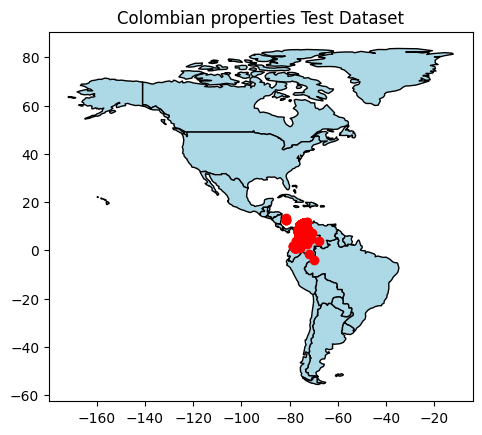

In [153]:
# For plotting the map:

# Map configuration
axis = world_data[(world_data.continent == 'South America') | (world_data.continent == 'North America')].plot(color='lightblue', edgecolor = 'black')

# Call a plot function from matplot lib

# Map with the properties where we can see that we have properties out of Colombia. Some of them are in Argentina and USA. The properties nearby Central America are in San Andres and Providencia,
# that are small islands that belong to Colombia.
test_geo.plot(ax = axis, color = 'red') # Creation of the points with the coordinates.
plt.title('Colombian properties Test Dataset')

In [154]:
# From the previous graph we can see that there are no records outside Colombia.
test_coor[(test_coor.latitud <= -20) | (test_coor.latitud >= 20)].index

Int64Index([], dtype='int64')

Text(0.5, 1.0, 'Colombian properties Dataset')

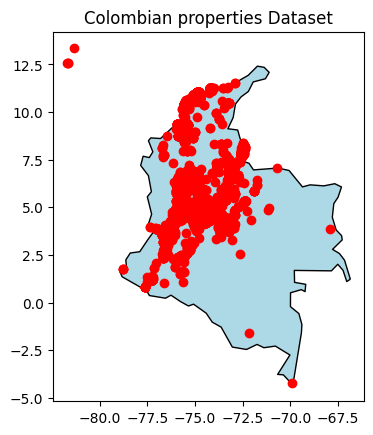

In [155]:
# In order for the user to see the records outside Colombia more clearly, we print another illustration
# clearer for the viewer.
axis = world_data[(world_data.name == 'Colombia')].plot(color='lightblue', edgecolor = 'black')
test_geo.plot(ax = axis,  color = 'red',figsize=(20,20))
plt.title('Colombian properties Dataset')

In [156]:
# In order to clean the dataframe some columns will be deleted because different factors that are explained below:

# pais: In this column all the records are Colombia.As is just one value it does not influence or affect the model.

# Sector: It is dropped because ???

# sector_bogota: This column is dropped due to it only contains information about Bogotá neighboorhouds, not taking into account information for other municipios (provinces).

# l6: contains a diminute proportion of data that can be used. It was not possible to fill null values with information from the column description, hence, it is eliminated.

# price: column used for calculating the target values. It is not used in the test dataset.

# currency: After deleting the records with values equal to USD, all the records are COP. As is just one value it does not influence or affect the model.

# title: This column was used for completing the columns rooms, bedrooms, bathrooms, surface_total, surface_covered. After that can be deleted.

# description: This column was used for completing the columns rooms, bedrooms, bathrooms, surface_total, surface_covered. After that can be deleted.

# operation_type : In this column all the records are Volombia.As is just one value it does not influence or affect the model.

# geometry: This column has records with information of latitude and longitude 

test.drop(['pais', 'sector', 'sector_bogota', 'l6', 'currency', 'price_period', 'title', 'description', 'operation_type', 'geometry'], axis=1, inplace=True)

#### Null values in 'rooms','bedrooms', 'bathrooms', 'surface_total' and 'surface_covered' columns

In [157]:
# Using an additional dataframe we are going to impute the NaN values with the mean of the the following columns rooms','bedrooms', 'bathrooms', 'surface_total', 'surface_covered',
# according to the type of property.
# This is done because a large amount of records are missing and we need to improve the data for the ML model. 
# The imputation is done according to the type of property, that is a column with complete records.
# Using this filtered mean allows us to fill empty spaces with a value more similar than just an average mean.

# Firstly, we create an empty dataframe where we will save the mean vallues.
empty = pd.DataFrame()

# Using the function groupby we obtain the mean for each type of property according to the different columns
empty = test.groupby('property_type').mean()

# The information is saved in the empty dataframe
empty = empty[['rooms','bedrooms', 'bathrooms', 'surface_total', 'surface_covered']].round()

C:\Users\Oscar Marino\AppData\Local\Temp\ipykernel_20844\2840134116.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  empty = test.groupby('property_type').mean()


In [158]:
empty

,rooms,bedrooms,bathrooms,surface_total,surface_covered
property_type,,,,,
Apartamento,3.0,3.0,2.0,117.0,9014.0
Casa,4.0,4.0,3.0,1081.0,267.0
Finca,4.0,4.0,4.0,18757.0,2952.0
Local comercial,4.0,2.0,2.0,141.0,136.0
Lote,3.0,1.0,2.0,6824.0,7183.0
Oficina,4.0,2.0,2.0,126.0,125.0
Otro,5.0,5.0,3.0,1074.0,1022.0
Parqueadero,3.0,2.0,1.0,490.0,470.0


In [159]:
# Using the dataframe Empty allow us to obtain the mean values for the the type of property according to the different columns.
# This values are kept in separate variables to use them to replace records with NaN values.

# Mean values for rooms by the type of property
r_a     = empty.iloc[0,0]
r_c     = empty.iloc[1,0]
r_f     = empty.iloc[2,0]
r_lc    = empty.iloc[3,0]
r_l     = empty.iloc[4,0]
r_o     = empty.iloc[5,0]
r_ot    = empty.iloc[6,0]
r_p     = empty.iloc[7,0]

print('Values for rooms:',r_a,r_c,r_f,r_lc,r_l,r_o,r_ot,r_p)

# Mean values for bedrooms according to the type of property
bed_a     = empty.iloc[0,1]
bed_c     = empty.iloc[1,1]
bed_f     = empty.iloc[2,1]
bed_lc    = empty.iloc[3,1]
bed_l     = empty.iloc[4,1]
bed_o     = empty.iloc[5,1]
bed_ot    = empty.iloc[6,1]
bed_p     = empty.iloc[7,1]

print('Values for bedrooms:',bed_a,bed_c,bed_f,bed_lc,bed_l,bed_o,bed_ot,bed_p)

# Mean values for bathrooms according to the type of property
bath_a     = empty.iloc[0,2]
bath_c     = empty.iloc[1,2]
bath_f     = empty.iloc[2,2]
bath_lc    = empty.iloc[3,2]
bath_l     = empty.iloc[4,2]
bath_o     = empty.iloc[5,2]
bath_ot    = empty.iloc[6,2]
bath_p     = empty.iloc[7,2]

print('Values for bathrooms:',bath_a,bath_c,bath_f,bath_lc,bath_l,bath_o,bath_ot,bath_p)

# Mean values for surface_total according to the type of property
surf_to_a     = empty.iloc[0,3]
surf_to_c     = empty.iloc[1,3]
surf_to_f     = empty.iloc[2,3]
surf_to_lc    = empty.iloc[3,3]
surf_to_l     = empty.iloc[4,3]
surf_to_o     = empty.iloc[5,3]
surf_to_ot    = empty.iloc[6,3]
surf_to_p     = empty.iloc[7,3]

print('Values for surface_total:',surf_to_a,surf_to_c,surf_to_f,surf_to_lc,surf_to_l,surf_to_o,surf_to_ot,surf_to_p)

# Mean values for surface_covered according to the type of property
surf_co_a     = empty.iloc[0,4]
surf_co_c     = empty.iloc[1,4]
surf_co_f     = empty.iloc[2,4]
surf_co_lc    = empty.iloc[3,4]
surf_co_l     = empty.iloc[4,4]
surf_co_o     = empty.iloc[5,4]
surf_co_ot    = empty.iloc[6,4]
surf_co_p     = empty.iloc[7,4]

print('Values for surface_covered:',surf_co_a,surf_co_c,surf_co_f,surf_co_lc,surf_co_l,surf_co_o,surf_co_ot,surf_co_p)

Values for rooms: 3.0 4.0 4.0 4.0 3.0 4.0 5.0 3.0
Values for bedrooms: 3.0 4.0 4.0 2.0 1.0 2.0 5.0 2.0
Values for bathrooms: 2.0 3.0 4.0 2.0 2.0 2.0 3.0 1.0
Values for surface_total: 117.0 1081.0 18757.0 141.0 6824.0 126.0 1074.0 490.0
Values for surface_covered: 9014.0 267.0 2952.0 136.0 7183.0 125.0 1022.0 470.0


In [ ]:
5/0

In [162]:
test[test.rooms.isnull() == True].index

Int64Index([    1,     2,     3,     4,     5,     6,     7,     9,    10,
               11,
            ...
            65839, 65840, 65841, 65842, 65843, 65844, 65846, 65847, 65848,
            65849],
           dtype='int64', length=56740)

In [ ]:
test.info()

In [ ]:
'''# For the column rooms where the record is NaN and in the same row the property_type is 'Apartamento' we are going to insert the value of the mean of rooms for Apartamento:
# We obtain the where the condition is met. It takes around 2 mins.
list_r_a = test[(np.isnan(test.rooms) == True) & (test.property_type == 'Apartamento')].index

# With a for cycle we iterate over the different index that met the condition. The records with this index are changed by the mean.
for i in test[(np.isnan(test.rooms) == True) & (test.property_type == 'Apartamento')].index:
    test.rooms[i] = r_a
    
# The same process is repeated for the other property types ('Casa', 'Finca', 'Local comercial', 'Lote', 'Oficina', 'Otro', 'Parqueadero').

list_r_c = test[(np.isnan(test.rooms) == True) & (test.property_type == 'Casa')].index
for i in list_r_c:
    test.rooms[i] = r_c
    
list_r_f = test[(np.isnan(test.rooms) == True) & (test.property_type == 'Finca')].index
for i in list_r_f:
    test.rooms[i] = r_f
    
list_r_lc = test[(np.isnan(test.rooms) == True) & (test.property_type == 'Local comercial')].index
for i in list_r_lc:
    test.rooms[i] = r_lc
    
list_r_l = test[(np.isnan(test.rooms) == True) & (test.property_type == 'Lote')].index
for i in list_r_l:
    test.rooms[i] = r_l
    
list_r_o = test[(np.isnan(test.rooms) == True) & (test.property_type == 'Oficina')].index
for i in list_r_o:
    test.rooms[i] = r_o
    
list_r_ot = test[(np.isnan(test.rooms) == True) & (test.property_type == 'Otro')].index
for i in list_r_ot:
    test.rooms[i] = r_ot
    
list_r_p = test[(np.isnan(test.rooms) == True) & (test.property_type == 'Parqueadero')].index
for i in list_r_p:
    test.rooms[i] = r_p'''

In [163]:
# For the column rooms where the record is NaN and in the same row the property_type is 'Apartamento' we are going to insert the value of the mean of rooms for Apartamento:
# We obtain the where the condition is met.

# For the column rooms

# We create a counter variable in order to manage the bucle and enter the mean value desired according to each column.
n = 0

# Creation of an iteration over the names of the columns of the Empty Dataframe.
for i in empty.index:
    # Using masks we filter the dataframe Train and obtain the index where the records are Nan and met a condition (type of property).
    list_index = test[(np.isnan(test.rooms) == True) & (test.property_type == i)].index
    # Using the index of the records that are NaN and the type of property desired, the value of this records are changed for the mean value of the type of property in the
    # suitable column.
    for j in list_index:
        if n == 0:
            test.rooms[j] = bed_a
        elif n == 1:
            test.rooms[j] = bed_c
        elif n == 2:
            test.rooms[j] = bed_f
        elif n == 3:
            test.rooms[j] = bed_lc
        elif n == 4:
            test.rooms[j] = bed_l
        elif n == 5:
            test.rooms[j] = bed_o
        elif n == 6:
            test.rooms[j] = bed_ot 
        elif n == 7:
            test.rooms[j] = bed_p
    n += 1


# The same process is repeated for the other columns.

# For the column bedrooms
n = 0
for i in empty.index:
    list_index = test[(np.isnan(test.bedrooms) == True) & (test.property_type == i)].index
    for j in list_index:
        if n == 0:
            test.bedrooms[j] = bed_a
        elif n == 1:
            test.bedrooms[j] = bed_c
        elif n == 2:
            test.bedrooms[j] = bed_f
        elif n == 3:
            test.bedrooms[j] = bed_lc
        elif n == 4:
            test.bedrooms[j] = bed_l
        elif n == 5:
            test.bedrooms[j] = bed_o
        elif n == 6:
            test.bedrooms[j] = bed_ot 
        elif n == 7:
            test.bedrooms[j] = bed_p
    n += 1


# For the column bathrooms
n = 0
for i in empty.index:
    list_index = test[(np.isnan(test.bathrooms) == True) & (test.property_type == i)].index
    for j in list_index:
        if n == 0:
            test.bathrooms[j] = bath_a
        elif n == 1:
            test.bathrooms[j] = bath_c
        elif n == 2:
            test.bathrooms[j] = bath_f
        elif n == 3:
            test.bathrooms[j] = bath_lc
        elif n == 4:
            test.bathrooms[j] = bath_l
        elif n == 5:
            test.bathrooms[j] = bath_o
        elif n == 6:
            test.bathrooms[j] = bath_ot 
        elif n == 7:
            test.bathrooms[j] = bath_p
    n += 1
    
# For the column surface_total
n = 0
for i in empty.index:
    list_index = test[(np.isnan(test.surface_total) == True) & (test.property_type == i)].index
    for j in list_index:
        if n == 0:
            test.surface_total[j] = surf_to_a
        elif n == 1:
            test.surface_total[j] = surf_to_c
        elif n == 2:
            test.surface_total[j] = surf_to_f
        elif n == 3:
            test.surface_total[j] = surf_to_lc
        elif n == 4:
            test.surface_total[j] = surf_to_l
        elif n == 5:
            test.surface_total[j] = surf_to_o
        elif n == 6:
            test.surface_total[j] = surf_to_ot 
        elif n == 7:
            test.surface_total[j] = surf_to_p
    n += 1
    
# For the column surface_covered
n = 0
for i in empty.index:
    list_index = test[(np.isnan(test.surface_covered) == True) & (test.property_type == i)].index
    for j in list_index:
        if n == 0:
            test.surface_covered[j] = surf_co_a
        elif n == 1:
            test.surface_covered[j] = surf_co_c
        elif n == 2:
            test.surface_covered[j] = surf_co_f
        elif n == 3:
            test.surface_covered[j] = surf_co_lc
        elif n == 4:
            test.surface_covered[j] = surf_co_l
        elif n == 5:
            test.surface_covered[j] = surf_co_o
        elif n == 6:
            test.surface_covered[j] = surf_co_ot 
        elif n == 7:
            test.surface_covered[j] = surf_co_p

C:\Users\Oscar Marino\AppData\Local\Temp\ipykernel_20844\1409005092.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.rooms[j] = bed_a
C:\Users\Oscar Marino\AppData\Local\Temp\ipykernel_20844\1409005092.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.rooms[j] = bed_c
C:\Users\Oscar Marino\AppData\Local\Temp\ipykernel_20844\1409005092.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.rooms[j] = bed_f
C:\Users\O

In [164]:
previous_outliers = test.copy()

## Outliers

In [ ]:
test.reset_index(drop=True, inplace=True)

In [ ]:
def outliers(df):
    index_to_drop = []
    for c in df[['latitud','longitud', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']]:
        q1 = df[c].quantile(0.25)
        q3 = df[c].quantile(0.75)
        iqr = q3 - q1
        uw = q3 + 1.5*iqr
        lw = q1 - 1.5*iqr
        index_iteration = df[(df[c] < lw) | (df[c] > uw)].index
        index_iteration = list(index_iteration)
        for i in index_iteration:
            if i not in index_to_drop:
                index_to_drop.append(i)
    return index_to_drop

In [ ]:
outliers = outliers(test)
len(outliers)

test.drop(outliers, axis=0, inplace=True)

test.shape

In [165]:
n = 0
for i in test[test.rooms.isnull() == True].index:
    if np.isnan(test.rooms[i]) :
        n += 1
print(n)

0


## Escalado/normalización

In [166]:
df_num = test[['latitud','longitud', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']]
df_num

,latitud,longitud,rooms,bedrooms,bathrooms,surface_total,surface_covered
0,4.722000,-74.075000,3.0,3.0,3.0,660.0,350.0
1,7.000008,-75.500009,3.0,3.0,3.0,117.0,9014.0
2,6.259253,-75.628381,4.0,4.0,1.0,1081.0,9014.0
3,6.203000,-75.556000,1.0,1.0,2.0,2793.0,9014.0
4,7.000008,-75.500009,4.0,4.0,2.0,1081.0,9014.0
...,...,...,...,...,...,...,...
65845,6.212981,-75.599349,3.0,3.0,2.0,117.0,9014.0
65846,5.041331,-75.512415,3.0,3.0,1.0,117.0,9014.0
65847,5.064733,-75.670570,5.0,5.0,2.0,1074.0,9014.0
65848,7.138641,-73.127312,3.0,3.0,2.0,117.0,9014.0


In [167]:
df_num.isnull().value_counts()

latitud  longitud  rooms  bedrooms  bathrooms  surface_total  surface_covered
False    False     False  False     False      False          False              65850
dtype: int64

In [169]:
# As the numerical variables have different measure scales and distributions, we are going to normalize the data using sklearn pre-processing functions.
# As there are several functions to rescale the data, we are going to apply a buch of them and see which one has better results.

# Import the desire library
from sklearn import preprocessing

# The MinMax scale the data taking the max and min value.It transform features by scaling each feature to a given range.
# The fit_transform receive the data and then transform and changed to numpy arrays.
data_min_max = preprocessing.MinMaxScaler().fit_transform(df_num)
data_min_max

# Debe ser borrado más adelante al igual que el comentario de abajo.
df_num_norm = df_num.copy()
df_num_norm.fillna(0, inplace=True)

# This function normalize the data using the magnitud of each vector (feature). It normalize samples individually to unit norm, in which each sample (each row of the data)
# is rescaled independently of other samples so that its norm  equals one.

# As the normalizer function works with the rows and not the columns we use the transpossed.
data_normalized = preprocessing.Normalizer().fit_transform(df_num.T)
data_normalized = data_normalized.T
data_normalized

# It works changing the data to obtain a standard deviation of 1 and a mean of 0, as some ml models work under the premise of data with a normal distribution.

# It transform features by scaling each feature to a given range usign the mean value of each feature.
data_standarized = preprocessing.StandardScaler().fit_transform(df_num)

# It transform features by scaling each feature to a given range usign the interquantile range of each feature. This functions work under the premise of avoiding outliers because they make noise.
data_standarized_robust = preprocessing.RobustScaler().fit_transform(df_num)

data_standarized, data_standarized_robust

(array([[-0.58187983,  1.01139305, -0.2457775 , ...,  0.33483943,
         -0.18435825, -0.1258425 ],
        [ 0.48795404, -0.38487106, -0.2457775 , ...,  0.33483943,
         -0.37798105,  0.00252661],
        [ 0.14006874, -0.51065361,  0.64298958, ..., -1.20787014,
         -0.03423817,  0.00252661],
        ...,
        [-0.4209203 , -0.55199208,  1.53175667, ..., -0.43651536,
         -0.03673423,  0.00252661],
        [ 0.55306069,  1.9399651 , -0.2457775 , ..., -0.43651536,
         -0.37798105,  0.00252661],
        [ 0.48795404, -0.38487106, -0.2457775 , ..., -0.43651536,
         -0.37798105,  0.00252661]]),
 array([[-2.07913759e-01,  9.85356771e-01,  0.00000000e+00, ...,
          1.00000000e+00,  5.63278008e-01, -8.66400000e+03],
        [ 7.62052153e-01,  0.00000000e+00,  0.00000000e+00, ...,
          1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 4.46641607e-01, -8.87659340e-02,  1.00000000e+00, ...,
         -1.00000000e+00,  1.00000000e+00,  0.00000000e+

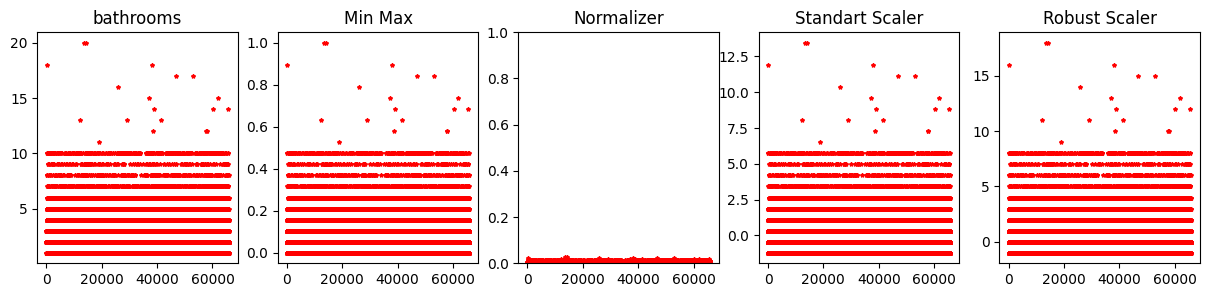

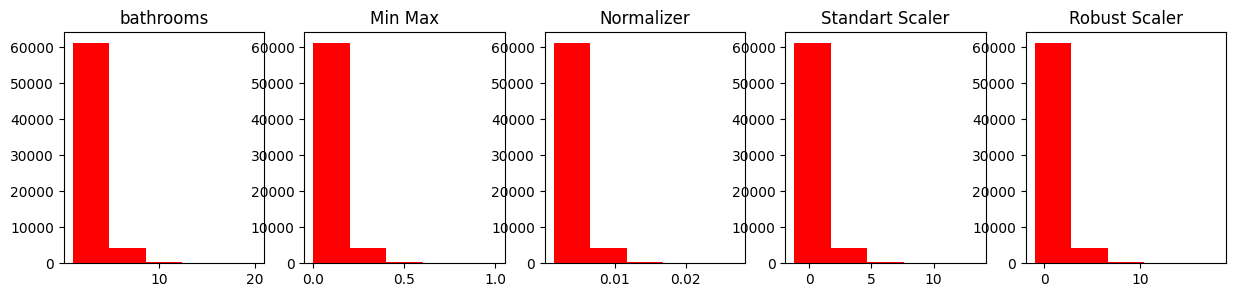

In [170]:
# Conversion of numpy arrays (vectors) into Dataframes to graph them.
data_min_max = pd.DataFrame(data_min_max, columns=['latitud','longitud', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered'])
data_normalized = pd.DataFrame(data_normalized, columns=['latitud','longitud', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered'])
data_standarized = pd.DataFrame(data_standarized, columns=['latitud','longitud', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered'])
data_standarized_robust = pd.DataFrame(data_standarized_robust, columns=['latitud','longitud', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered'])

# Creation of a figure of 5 subplots to compare the methods appleid.
fig = plt.figure(figsize = (15,3))
ax1 = fig.add_subplot(1, 5, 1)
ax2 = fig.add_subplot(1, 5, 2)
ax3 = fig.add_subplot(1, 5, 3)
ax4 = fig.add_subplot(1, 5, 4)
ax5 = fig.add_subplot(1, 5, 5)

# Personalization of the different subplots.
ax1.set_title('bathrooms')
ax1.plot(df_num['bathrooms'], linewidth = 0, marker = '*', color='r', markersize = 3)

ax2.set_title('Min Max')
ax2.plot(data_min_max['bathrooms'], linewidth = 0, marker = '*', color='r', markersize = 3)

ax3.set_title('Normalizer')
ax3.plot(data_normalized['bathrooms'], linewidth = 0, marker = '*', color='r', markersize = 3)
ax3.set_ylim(0, 1)

ax4.set_title('Standart Scaler')
ax4.plot(data_standarized['bathrooms'], linewidth = 0, marker = '*', color='r', markersize = 3)

ax5.set_title('Robust Scaler')
ax5.plot(data_standarized_robust['bathrooms'], linewidth = 0, marker = '*', color='r', markersize = 3)

plt.show()

# Creation of a figure of 5 subplots to illustrate the histograms.
fig = plt.figure(figsize = (15,3))
ax1 = fig.add_subplot(1, 5, 1)
ax2 = fig.add_subplot(1, 5, 2)
ax3 = fig.add_subplot(1, 5, 3)
ax4 = fig.add_subplot(1, 5, 4)
ax5 = fig.add_subplot(1, 5, 5)

ax1.set_title('bathrooms')
ax1.hist(df_num['bathrooms'], linewidth = 0, color='r', bins=5)

ax2.set_title('Min Max')
ax2.hist(data_min_max['bathrooms'], linewidth = 0, color='r', bins=5)

ax3.set_title('Normalizer')
ax3.hist(data_normalized['bathrooms'], linewidth = 0, color='r', bins=5)

ax4.set_title('Standart Scaler')
ax4.hist(data_standarized['bathrooms'], linewidth = 0, color='r', bins=5)

ax5.set_title('Robust Scaler')
ax5.hist(data_standarized_robust['bathrooms'], linewidth = 0, color='r', bins=5)

plt.show()

In [171]:
df_num

,latitud,longitud,rooms,bedrooms,bathrooms,surface_total,surface_covered
0,4.722000,-74.075000,3.0,3.0,3.0,660.0,350.0
1,7.000008,-75.500009,3.0,3.0,3.0,117.0,9014.0
2,6.259253,-75.628381,4.0,4.0,1.0,1081.0,9014.0
3,6.203000,-75.556000,1.0,1.0,2.0,2793.0,9014.0
4,7.000008,-75.500009,4.0,4.0,2.0,1081.0,9014.0
...,...,...,...,...,...,...,...
65845,6.212981,-75.599349,3.0,3.0,2.0,117.0,9014.0
65846,5.041331,-75.512415,3.0,3.0,1.0,117.0,9014.0
65847,5.064733,-75.670570,5.0,5.0,2.0,1074.0,9014.0
65848,7.138641,-73.127312,3.0,3.0,2.0,117.0,9014.0


In [175]:
data_standarized.to_csv('test_corrected')

In [176]:
data_standarized

,latitud,longitud,rooms,bedrooms,bathrooms,surface_total,surface_covered
0,-0.581880,1.011393,-0.245778,-0.205585,0.334839,-0.184358,-0.125843
1,0.487954,-0.384871,-0.245778,-0.205585,0.334839,-0.377981,0.002527
2,0.140069,-0.510654,0.642990,0.580032,-1.207870,-0.034238,0.002527
3,0.113650,-0.439733,-2.023312,-1.776818,-0.436515,0.576226,0.002527
4,0.487954,-0.384871,0.642990,0.580032,-0.436515,-0.034238,0.002527
...,...,...,...,...,...,...,...
65845,0.118338,-0.482207,-0.245778,-0.205585,-0.436515,-0.377981,0.002527
65846,-0.431910,-0.397027,-0.245778,-0.205585,-1.207870,-0.377981,0.002527
65847,-0.420920,-0.551992,1.531757,1.365649,-0.436515,-0.036734,0.002527
65848,0.553061,1.939965,-0.245778,-0.205585,-0.436515,-0.377981,0.002527
